In [1]:
import os
import argparse
import numpy as np
import cv2
from utils import *
from background_marker import *
import cv2
from tqdm import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
from keras.models import model_from_json

def generate_background_marker(file):
    """
    Generate background marker for an image

    Args:
        file (string): full path of an image file

    Returns:
        tuple[0] (ndarray of an image): original image
        tuple[1] (ndarray size of an image): background marker
    """

    # check file name validity
    if not os.path.isfile(file):
        raise ValueError('{}: is not a file'.format(file))

    original_image = read_image(file)

    marker = np.full((original_image.shape[0], original_image.shape[1]), True)

    # update marker based on vegetation color index technique
    color_index_marker(index_diff(original_image), marker)

    # update marker to remove blues
    # remove_blues(original_image, marker)

    return original_image, marker


def segment_leaf(image_file, filling_mode, smooth_boundary, marker_intensity):
    """
    Segments leaf from an image file

    Args:
        image_file (string): full path of an image file
        filling_mode (string {no, flood, threshold, morph}): 
            how holes should be filled in segmented leaf
        smooth_boundary (boolean): should leaf boundary smoothed or not
        marker_intensity (int in rgb_range): should output background marker based
                                             on this intensity value as foreground value

    Returns:
        tuple[0] (ndarray): original image to be segmented
        tuple[1] (ndarray): A mask to indicate where leaf is in the image
                            or the segmented image based on marker_intensity value
    """
    # get background marker and original image
    original, marker = generate_background_marker(image_file)

    # set up binary image for futher processing
    bin_image = np.zeros((original.shape[0], original.shape[1]))
    bin_image[marker] = 255
    bin_image = bin_image.astype(np.uint8)

    # further processing of image, filling holes, smoothing edges
    largest_mask = select_largest_obj(bin_image, fill_mode=filling_mode,
                           smooth_boundary=smooth_boundary)

    if marker_intensity > 0:
        largest_mask[largest_mask != 0] = marker_intensity
        image = largest_mask
    else:
        # apply marker to original image
        image = original.copy()
        image[largest_mask == 0] = np.array([0, 0, 0])

    return original, image


def rgb_range(arg):
    """
    Check if arg is in range for rgb value(between 0 and 255)

    Args:
        arg (int convertible): value to be checked for validity of range

    Returns:
        arg in int form if valid

    Raises:
        argparse.ArgumentTypeError: if value can not be integer or not in valid range
    """

    try:
        value = int(arg)
    except ValueError as err:
        raise argparse.ArgumentTypeError(str(err))

    if value < 0 or value > 255:
        message = "Expected 0 <= value <= 255, got value = {}".format(value)
        raise argparse.ArgumentTypeError(message)

    return value


def segment(image_source):
    marker_intensity=0
    fill='flood'
    smooth=True
    destination="test images/"
    
    # set up command line arguments conveniently
    filling_mode = FILL[fill.upper()]
    
    folder, file = os.path.split(image_source)
    files = [file]
    base_folder = folder
    #print(1)
    # set up destination folder for segmented output
    if destination:
        destination = destination
    else:
        destination = folder
    #print(files)
    
    for file in files:
            # read image and segment leaf
            #print(os.path.join(base_folder, file))
            original, output_image = segment_leaf(image_source, filling_mode, smooth, marker_intensity)
            
            # handle destination folder and fileaname
            filename, ext = os.path.splitext(file)
            
            new_filename = filename + '_marked' + ext
            new_filename = os.path.join(destination, new_filename)

            # change grayscale image to color image format i.e need 3 channels
            if marker_intensity > 0:
                output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2RGB)

            # write the output
            #cv2.imwrite(new_filename, output_image)
            return output_image
        
        
def predict_disease(image_path):
    # load json and create model
    json_file = open('weights/VGG16_onlycropdetect/VGG16_onlycropdetect_model.json', 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights("weights/VGG16_onlycropdetect/vgg16_onlycropdetect__best.hdf5")
    
    with open('crop_labels.json', 'r') as fp:
        dic = json.load(fp)
        
    im = segment(image_path)
    
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
    plt.imshow(im)
    im = np.expand_dims(im, axis =0)
    im=cv2.normalize(im.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    
    
    outcome=model.predict(im)
    
    pred=np.argmax(outcome)
    crop_label_predicted=dic[str(pred)]
    
    
    json_model_path='after_crop_disease_detection/weights/VGG16_'+crop_label_predicted+'_model.json'
    saved_weight_path='after_crop_disease_detection/weights/vgg16_best_'+crop_label_predicted+'.hdf5'
    label_path='after_crop_disease_detection/labels/'+crop_label_predicted+'_label.json'

    json_file = open(json_model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(saved_weight_path)
    #print("Loaded model from disk")
    
    
    with open(label_path, 'r') as fp:
        dic = json.load(fp)
        
    outcome=model.predict(im)
    pred=sorted(((e,i) for i,e in enumerate(outcome[0])),reverse=True)
    
    out=[]
    for x in pred:
        #print("predited class:",dic[str(x[1])],"  with confidence: ",x[0]*100,"%")
        out.append((dic[str(x[1])],x[0]*100))
        
    return out

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[('Grape___Black_rot', 100.0),
 ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 1.4395365596168302e-12),
 ('Grape___Esca_(Black_Measles)', 9.924341147602052e-13),
 ('Grape___healthy', 5.167308612857098e-15)]

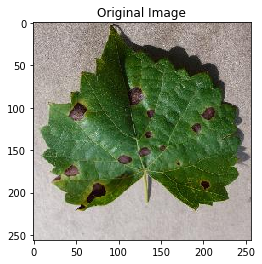

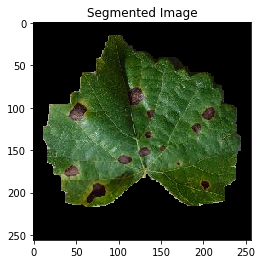

In [2]:
import matplotlib.pyplot as plt
plt.figure(num=1)
plt.title("Original Image")
im = cv2.imread("test images/grape_blackrot.jpg")
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
plt.imshow(im)
plt.figure(num=2)
plt.title("Segmented Image")
predict_disease('test images/grape_blackrot.jpg')

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [52]:
img = cv2.imread("888.png")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
stencil = np.zeros(img.shape).astype(img.dtype)
c=[255,0,0]
indices = np.where(np.all(img == c, axis=-1))
a=indices[1]
b=indices[0]
x_mn=min(a)
x_mx=max(a)
y_mn=min(b)
y_mx=max(b)
print(x_mn,x_mx)
print(y_mn,y_mx)


img_org = cv2.imread("6666.png")
img_org=cv2.cvtColor(img_org,cv2.COLOR_BGR2RGB)

#img2=cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

#img2=img2[y_mn:y_mx,x_mn:x_mx]
#plt.imshow(img2)
#cv2.imwrite("res2.png", img2)
indices=np.concatenate((np.expand_dims(a,1),np.expand_dims(b,1)),axis=1)
contours=[indices]
#contours =[np.array([[x_mn,y_mn],[x_mn,y_mx],[x_mx,y_mx],[x_mx,y_mn]])]
stencil = np.zeros(img.shape).astype(img.dtype)
img2=cv2.drawContours(stencil,contours,-1,(255,255,255),thickness=cv2.FILLED)

#xcolor = [255,255,255]
#cv2.fillPoly(stencil, contours, color)
result = cv2.bitwise_and(img_org,img2)
result=result[y_mn:y_mx,x_mn:x_mx]
plt.imshow(result)
cv2.imwrite("res.png", result)

error: OpenCV(3.4.5) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [10]:
from googletrans import Translator
translator = Translator()

In [20]:
translator.translate("Predicted Disease is Tomato late blight",dest='hi').text

'पूर्वानुमानित रोग टमाटर की लेट ब्लाइट है'

In [26]:
from imageai.Detection import ObjectDetection
import os

execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.0.1.h5"))
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , "spinach.jpg"), output_image_path=os.path.join(execution_path , "imagenew.jpg"))

for eachObject in detections:
    print(eachObject["name"] , " : " , eachObject["percentage_probability"] )